In [1]:
# Es una buena idea asegurarse de que estés utilizando la última versión de las bibliotecas que necesitas.
# !pip install -Uqq <bibliotecas> actualiza a la última versión de <bibliotecas>
# Nota: Puedes ignorar de manera segura cualquier advertencia o error que pip muestre acerca de ejecutarse como root o incompatibilidades"
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai numpy pandas

**Importante: Activa los aceleradores GPU T4 x2 en los tres puntos al lado del estado de tu sesión. Esto te permitirá entrenar este modelo mucho más rápido**
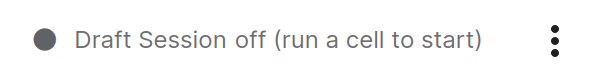

In [2]:
from fastai.tabular.all import *
import pandas as pd
import numpy

# Paso 1. Preparación de los Datos
En este proyecto utilizamos los datos del Titanic proveídos por Kaggle.

In [4]:
train_df = pd.read_csv('/kaggle/input/titanic/train.csv') # Training set
test_df = pd.read_csv('/kaggle/input/titanic/test.csv') # Test set

## 1.1 Visualización de los datos

In [5]:
train_df.head() # Visualización del dataset

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_df.describe() # Visualización de datos importantes del dataset

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Procesar datos
Definimos las columnas categóricas, numéricas y la variable objetivo. Pre-procesamos los datos asegurando su **normalización**, **categorización** y **que no existan datos vacíos**. Posteriormente, usamos el objeto *TabularPandas* de la librería fastai para definir la arquitectura de tu modelo para luego entrenarlo.

In [27]:
splits = RandomSplitter(valid_pct=0.15, seed=1000)(range_of(train_df))

In [28]:
tab = TabularPandas(
        train_df, 
        cat_names=['Sex', 'Cabin', 'Embarked', 'Ticket'], 
        cont_names=['Age', 'Pclass', 'SibSp', 'Parch', 'Fare'], 
        y_names='Survived',
        procs=[Categorify, FillMissing, Normalize],
        y_block=CategoryBlock(),
        splits=splits
    )

In [29]:
dls = tab.dataloaders(bs=32)

In [30]:
dls.show_batch()

,Sex,Cabin,Embarked,Ticket,Age_na,Age,Pclass,SibSp,Parch,Fare,Survived
0,male,#na#,C,P/PP 3381,False,30.000000,2.0,1.000000e+00,3.908293e-09,24.000000,0
1,male,#na#,Q,371110,True,28.000000,3.0,1.000000e+00,3.908293e-09,24.149999,0
2,male,#na#,S,31027,False,34.000000,2.0,1.000000e+00,3.908293e-09,21.000000,0
3,male,#na#,C,2683,False,34.500000,3.0,7.572246e-09,3.908293e-09,6.437500,0
4,male,C148,C,111369,False,26.000000,1.0,7.572246e-09,3.908293e-09,30.000000,1
5,female,D35,S,11751,False,47.000000,1.0,1.000000e+00,1.000000e+00,52.554199,1
6,female,#na#,S,26360,False,1.999999,2.0,1.000000e+00,1.000000e+00,26.000000,1
7,female,#na#,S,F.C.C. 13531,False,50.000000,2.0,7.572246e-09,3.908293e-09,10.500000,1
8,male,#na#,S,363294,False,34.000000,3.0,7.572246e-09,3.908293e-09,8.050001,0
9,male,#na#,S,376566,False,24.000000,3.0,1.000000e+00,3.908293e-09,16.100000,0


# Entrenamiento del Modelo

SuggestedLRs(valley=0.0063095735386013985)

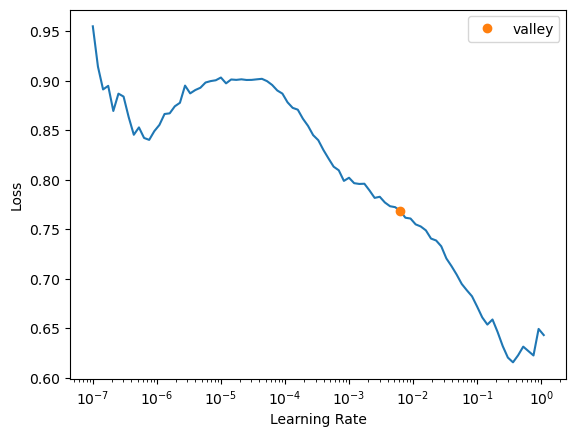

In [50]:
learn = tabular_learner(dls, metrics=accuracy)
#learn.fit_one_cycle(10)
learn.lr_find()

In [52]:
learn.fit(5,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.072597,0.623469,0.819549,00:00
1,0.079297,0.651038,0.834586,00:00
2,0.061739,0.712604,0.834586,00:00
3,0.050900,0.849161,0.842105,00:00
4,0.048742,0.730195,0.834586,00:00


# Predicciones

Primero rellenamos los valores de ´Fare´dentro de test_df que tengán un valor Na.

In [53]:
fare_med_val = test_df.Fare.median()
test_df = test_df.copy()
test_df.loc[:, 'Fare'].fillna(fare_med_val, inplace=True)

In [54]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Evaluamos con los datos de Test

In [57]:
t1 = learn.dls.train_ds.new(test_df)
t1.process()

dl = TabDataLoader(t1)

In [58]:
preds = learn.get_preds(dl=dl)[0].argmax(1).numpy()

A partir de las predicciones, generamos un csv listo para enviar a la competencia de kaggle.

In [59]:
out = pd.DataFrame({'PassengerId':test_df.PassengerId, 'Survived': preds.astype(int)})
out.to_csv('submission_1.csv', index=False)
out.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


## Análisis de predicciones

A través de la matriz de confusión podemos ver que predicciones están fallando.

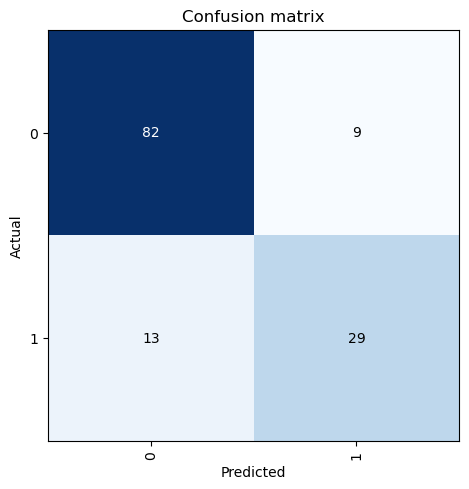

In [60]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()